# Imports

In [20]:
import tensorflow
from keras import layers
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# Tensorflow version

In [39]:
print("TensorFlow version:", tensorflow.__version__)

TensorFlow version: 2.18.0


# Extract dataset.zip from google cloud

### Notes:

Helpful documentations:
https://docs.python.org/3/library/zipfile.html

In [21]:
zipped_path = "/content/drive/MyDrive/Colab_Notebooks/hagridset.zip"
dataset_path = "/unzipped_dataset"

with zipfile.ZipFile(zipped_path, 'r') as zip_ref:
    zip_ref.extractall(dataset_path)

# image_dataset_from_directory

This receives an entire dataset and automates the preprocessing of the data. The different choices made for parameters are explained below

resource provided by lecturer:  
https://www.tensorflow.org/tutorials/load_data/images

## Get training set

In [22]:
IMG_SIZE = (128, 128)# For resnet50 transfer learning

train_data = tensorflow.keras.utils.image_dataset_from_directory(
    directory=(dataset_path+"/hagridset/"), # Enter the dataset (so classification is done properly)
    labels="inferred",                      # Auto-label
    label_mode="categorical",               # one hot encoding
    batch_size=32,
    image_size=IMG_SIZE,                    # This size is compatible with VGG16 and ResNet transfer learning
    validation_split=0.2,                   # Holds 20% for validation
    subset="training",                      # Take 80%
    seed=401808,                            # Student ID seed
)

# Get class names
class_names = train_data.class_names

# Cache results and pre-process next batch
train_data = train_data.cache(filename="./train_cache").prefetch(tensorflow.data.AUTOTUNE)

Found 125912 files belonging to 18 classes.
Using 100730 files for training.


## Get test set

In [23]:
validation_data = tensorflow.keras.utils.image_dataset_from_directory(
    directory=(dataset_path+"/hagridset/"),
    labels="inferred",
    label_mode="categorical",
    batch_size=32,
    image_size=IMG_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=401808,
).cache(filename="./test_cache").prefetch(tensorflow.data.AUTOTUNE)

Found 125912 files belonging to 18 classes.
Using 25182 files for validation.


## Print some sample input and its output

I modified the printExamples method for easy display of the dataset:  
https://github.com/Kevin-2002/Gesture_Based_UI_Development/blob/main/week5/digits.ipynb

<Figure size 1000x1000 with 0 Axes>

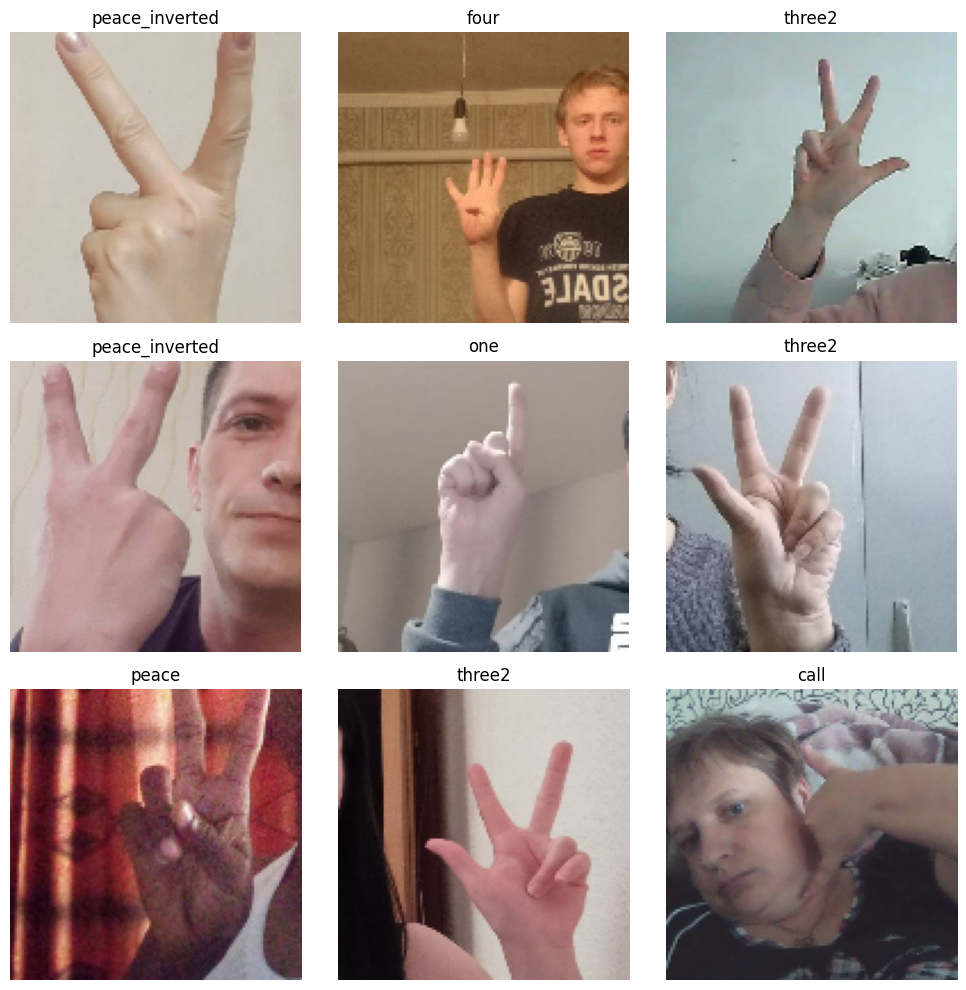

In [24]:
plt.figure(figsize=(10, 10))

def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    num_samples=9

    # Take one batch from the dataset
    for images, labels in dataset.take(1):
        # Convert one-hot encoded labels back to class indices
        label_indices = tensorflow.argmax(labels, axis=1)

        for i in range(min(num_samples, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[label_indices[i]])
            plt.axis("off")

    plt.tight_layout()
    plt.show()

visualize_dataset(train_data, class_names)

# Build CNN from scratch

In [25]:
data_augmentation = tensorflow.keras.Sequential([
    layers.RandomFlip("horizontal", seed=401808),
    layers.RandomRotation(0.2, seed=401808),
    layers.RandomZoom(0.2, seed=401808),
    layers.RandomContrast(0.2, seed=401808),
])

In [26]:
model_cnn = tensorflow.keras.models.Sequential()

model_cnn.add(tensorflow.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1],3)))
model_cnn.add(layers.Rescaling(1./255))

# Input
model_cnn.add(layers.Conv2D(32, 3, padding='same', activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D())
model_cnn.add(layers.Dropout(0.2))

model_cnn.add(layers.Conv2D(64, 3, padding='same', activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D())
model_cnn.add(layers.Dropout(0.3))

model_cnn.add(layers.Conv2D(128, 3, padding='same', activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.MaxPooling2D())
model_cnn.add(layers.Dropout(0.4))

model_cnn.add(layers.Flatten())
model_cnn.add(layers.Dense(256, activation='relu'))
model_cnn.add(layers.BatchNormalization())
model_cnn.add(layers.Dropout(0.5))
model_cnn.add(layers.Dense(len(class_names), activation='softmax'))

In [27]:
model_cnn.compile(optimizer=tensorflow.keras.optimizers.Adam(),
              loss=tensorflow.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [28]:
model_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 18)             │         4,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,488,658 (32.38 MB)

 Trainable params: 8,487,698 (32.38 MB)

 Non-trainable params: 960 (3.75 KB)

In [29]:
callback = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
CNN_history = model_cnn.fit(train_data,  validation_data=(validation_data), epochs=100, callbacks=[callback])

Epoch 1/100
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.1822 - loss: 2.8344 - val_accuracy: 0.2687 - val_loss: 5.3971
Epoch 2/100
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.4569 - loss: 1.6718 - val_accuracy: 0.6157 - val_loss: 1.2075
Epoch 3/100
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.5832 - loss: 1.2718 - val_accuracy: 0.6231 - val_loss: 1.1839
Epoch 4/100
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6501 - loss: 1.0598 - val_accuracy: 0.7479 - val_loss: 0.8016
Epoch 5/100
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.6945 - loss: 0.9171 - val_accuracy: 0.7552 - val_loss: 0.7756
Epoch 6/100
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.7244 - loss: 0.8366 - val_accuracy: 0.7280 - val_loss: 0.8508
Epoch 7/100
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.7448 - loss: 0.7715 - val_accuracy: 0.7692 - val_loss: 0.7299
Epoch 8/100
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.7689 -

# Transfer learning

The following code is based off of the following guides:  
https://medium.com/@paravisionlab/supercharge-your-ai-resnet50-transfer-learning-unleashed-b7c0e40976c4  
https://github.com/Kevin-2002/Gesture_Based_UI_Development/blob/main/week12/Pokemon/pikachueeveebulbasaur%20(2).ipynb

In [31]:
base_model = tensorflow.keras.applications.ResNet50(
    weights='imagenet',  # Pre-trained on ImageNet
    include_top=False,   # Don't include the classifier at the top
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

# Freeze the base model
base_model.trainable = False

# Build the model
inputs = tensorflow.keras.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
x = data_augmentation(inputs)
x = tensorflow.keras.applications.resnet.preprocess_input(x)  # ResNet specific preprocessing
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = tensorflow.keras.Model(inputs, outputs)

# Compile the model
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(),
    loss=tensorflow.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()

# Callbacks
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 128, 128,  │          0 │ input_layer_6[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_3          │ (None, 128, 128)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_4          │ (None, 128, 128)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_5          │ (None, 128, 128)  │          0 │ sequential_2[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack_1 (Stack)     │ (None, 128, 128,  │          0 │ get_item_3[0][0], │
│                     │ 3)                │            │ get_item_4[0][0], │
│                     │                   │            │ get_item_5[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128, 128,  │          0 │ stack_1[0][0]     │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 4, 4,      │ 23,587,712 │ add_1[0][0]       │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 18)        │      4,626 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,116,882 (92.00 MB)

 Trainable params: 529,170 (2.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [32]:
# Train the model
first_model = model.fit(
    train_data,
    epochs=50,
    validation_data=validation_data,
    callbacks=[early_stopping]
)

Epoch 1/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 69s 19ms/step - accuracy: 0.1688 - loss: 2.5916 - val_accuracy: 0.4168 - val_loss: 1.7394
Epoch 2/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.2677 - loss: 2.2129 - val_accuracy: 0.4466 - val_loss: 1.6443
Epoch 3/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.2879 - loss: 2.1445 - val_accuracy: 0.4738 - val_loss: 1.5649
Epoch 4/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.3014 - loss: 2.0996 - val_accuracy: 0.4719 - val_loss: 1.5663
Epoch 5/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.3022 - loss: 2.0847 - val_accuracy: 0.4872 - val_loss: 1.5173
Epoch 6/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.3121 - loss: 2.0658 - val_accuracy: 0.4967 - val_loss: 1.5137
Epoch 7/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.3176 - loss: 2.0541 - val_accuracy: 0.4894 - val_loss: 1.5218
Epoch 8/50
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 59s 19ms/step - accuracy: 0.3189 -

In [33]:
# Optional: Fine-tuning
# Unfreeze some layers of the base model
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(
    optimizer=tensorflow.keras.optimizers.Adam(),
    loss=tensorflow.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

# Update callbacks to 3 for best fit
early_stopping = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [34]:
# Continue training
history_fine = model.fit(
    train_data,
    epochs=25,
    initial_epoch=first_model.epoch[-1],
    validation_data=validation_data,
    callbacks=[early_stopping]
)


Epoch 19/25
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 164s 46ms/step - accuracy: 0.5229 - loss: 1.4646 - val_accuracy: 0.8402 - val_loss: 0.4957
Epoch 20/25
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 142s 45ms/step - accuracy: 0.8125 - loss: 0.6062 - val_accuracy: 0.8935 - val_loss: 0.3369
Epoch 21/25
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 144s 46ms/step - accuracy: 0.8633 - loss: 0.4540 - val_accuracy: 0.9033 - val_loss: 0.3322
Epoch 22/25
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 144s 46ms/step - accuracy: 0.8829 - loss: 0.3956 - val_accuracy: 0.9233 - val_loss: 0.2551
Epoch 23/25
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 142s 45ms/step - accuracy: 0.8991 - loss: 0.3393 - val_accuracy: 0.9276 - val_loss: 0.2410
Epoch 24/25
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 141s 45ms/step - accuracy: 0.9175 - loss: 0.2762 - val_accuracy: 0.9252 - val_loss: 0.2343
Epoch 25/25
3148/3148 ━━━━━━━━━━━━━━━━━━━━ 141s 45ms/step - accuracy: 0.9213 - loss: 0.2596 - val_accuracy: 0.9311 - val_loss: 0.2303


# Test the models on new data

In [40]:
def prepare_image(image_path):
    img = Image.open(image_path)
    img = img.resize((128, 128))
    img_array = np.array(img) / 255.0
    return np.expand_dims(img_array, axis=0)

# Test images (replace with your actual file paths)
test_images = [
    '/content/drive/MyDrive/test_photos/one.jpg',
    '/content/drive/MyDrive/test_photos/palm.jpg',
    '/content/drive/MyDrive/test_photos/three2.jpg',
    '/content/drive/MyDrive/test_photos/two_up.jpg'
]

# Predict on each image
for img_path in test_images:
    processed_img = prepare_image(img_path)
    predictions = model.predict(processed_img)
    predictions_cnn = model_cnn.predict(processed_img)
    predicted_class = class_names[np.argmax(predictions)]
    predicted_class_cnn = class_names[np.argmax(predictions_cnn)]
    print(f"Current image: {img_path}, Predicted class: {predicted_class}, cnn_prediction: {predicted_class_cnn}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Current image: /content/drive/MyDrive/test_photos/one.jpg, Predicted class: fist, cnn_prediction: one
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Current image: /content/drive/MyDrive/test_photos/palm.jpg, Predicted class: fist, cnn_prediction: one
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Current image: /content/drive/MyDrive/test_photos/three2.jpg, Predicted class: fist, cnn_prediction: one
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Current image: /content/drive/MyDrive/test_photos/two_up.jpg, Predicted class: fist, cnn_prediction: one
